In [1]:
!pip install pytesseract

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytesseract

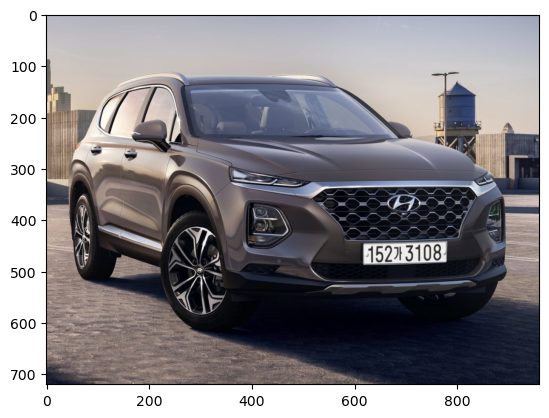

In [3]:
image_path = '../Data/car2.png'
image = cv2.imread(image_path)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

h_, w_, c = image.shape

plt.imshow(image)
plt.show()

#print('이미지 크기>>', h_, w_, c)

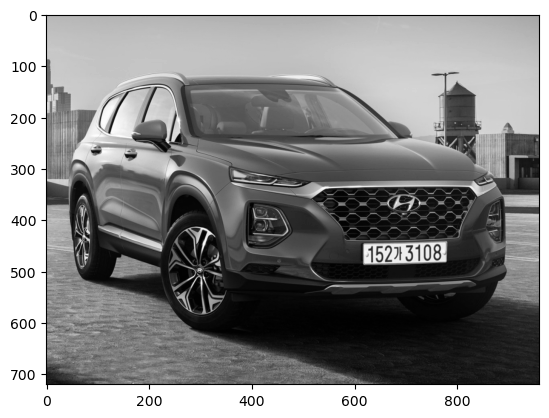

In [4]:
#차량 이미지 grayscale로 변환

gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

plt.imshow(gray_image, 'gray')
plt.show()



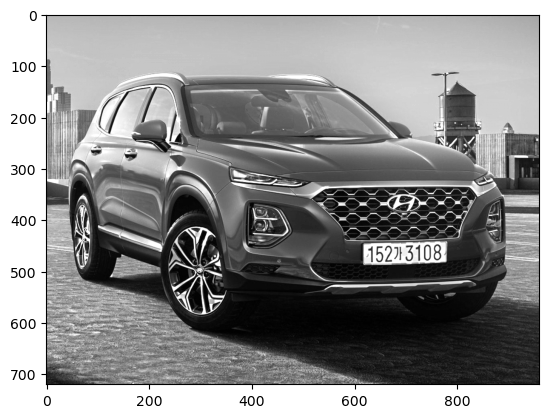

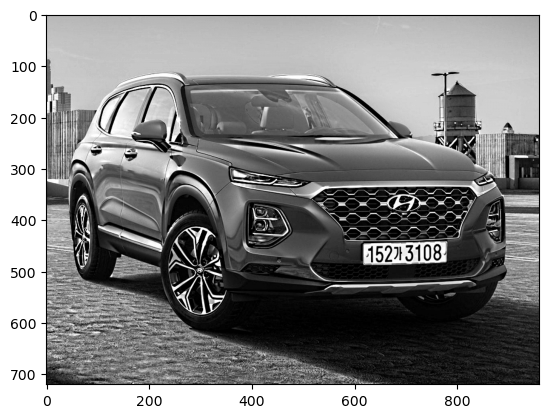

In [5]:
# Maximize Contrast
# 모폴로지 연산 사용.

structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9)) #1로 채워진 9*9 행렬 만들기. 커널 값임.
#print(structuringElement)

#TOPHAT -> 밝기 값이 크게 변화하는 영역을 강조
imgTopHat = cv2.morphologyEx(gray_image, cv2.MORPH_TOPHAT, structuringElement)

#plt.imshow(imgTopHat, 'gray')
#plt.show()

#BLACKHAT -> 어두운 부분을 강조
imgBlackHat = cv2.morphologyEx(gray_image, cv2.MORPH_BLACKHAT, structuringElement)

#plt.imshow(imgBlackHat, 'gray')
#plt.show()

# 합치기.
imgAdd = cv2.add(gray_image, imgTopHat)
plt.imshow(imgAdd, 'gray')
plt.show()

# 빼기
imgMinus = cv2.subtract(imgAdd, imgBlackHat)
plt.imshow(imgMinus, 'gray')
plt.show()

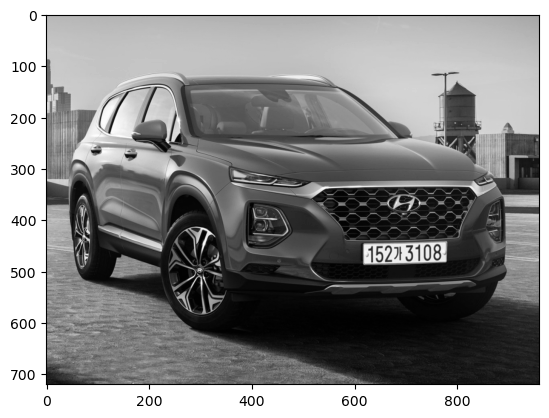

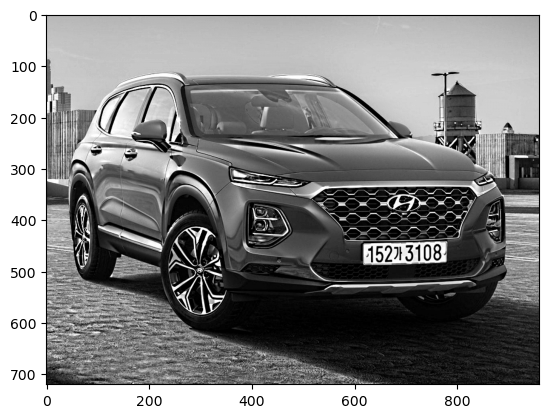

In [6]:
#원본과 비교

plt.imshow(gray_image, 'gray')
plt.show()

plt.imshow(imgMinus, 'gray')
plt.show()

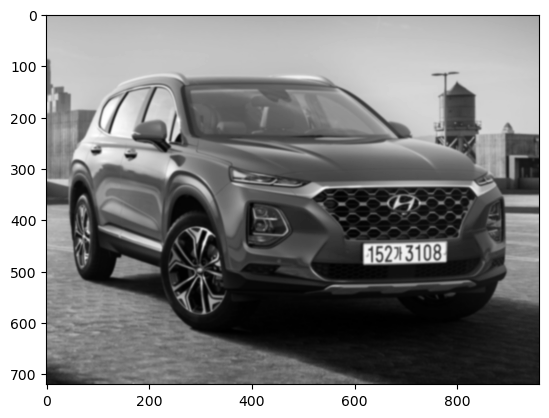

In [7]:
# 이진화

img_blurred = cv2.GaussianBlur(gray_image, ksize = (7,7), sigmaX = 0)

plt.imshow(img_blurred, 'gray')
plt.show()

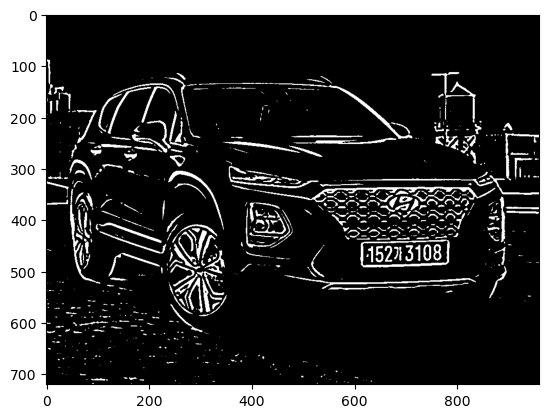

In [8]:
img_thresh = cv2.adaptiveThreshold(
        img_blurred,
        maxValue = 255.0,
        adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType = cv2.THRESH_BINARY_INV,
        blockSize = 15, #주변 픽셀 크기 지정. 홀수.
        C = 9
)

plt.imshow(img_thresh, 'gray')
plt.show()

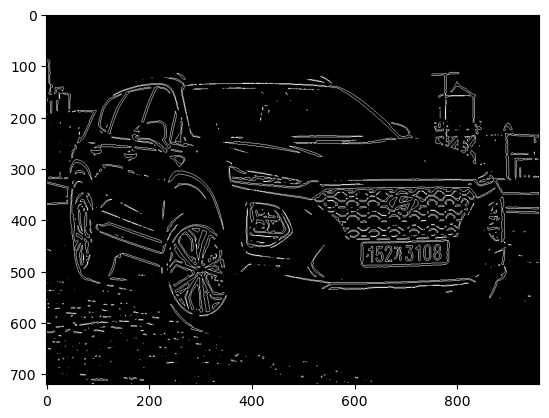

In [9]:
#차량 이미지 - Find Countours(이미지에서 객체의 외각선 검출)

contours, hierarchy = cv2.findContours(
    img_thresh,
    mode = cv2.RETR_LIST,
    method = cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((h_, w_, c), dtype = np.uint8) # 원본 이미지 hwc값 받아오기.

#print(contours) #img thresh의 윤곽선 좌표

cv2.drawContours(temp_result, contours = contours, contourIdx = -1, color = (255, 255, 255))

plt.imshow(temp_result, 'gray')
plt.show()

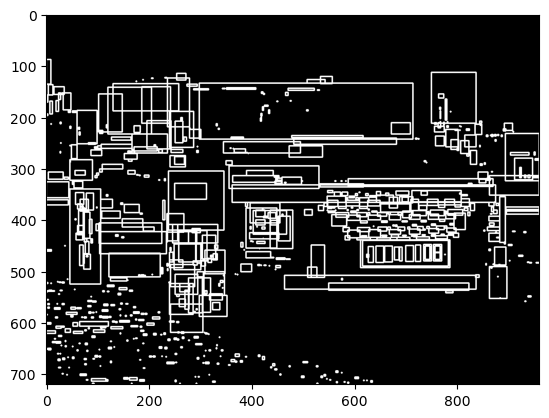

In [10]:
#bounding Box 표시

temp_result = np.zeros((h_, w_, c), dtype = np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    #print(x, y, w, h)
    cv2.rectangle(temp_result, (x,y), (x+w, y+h), (255, 255, 255), thickness = 2)
    
    #insert to dict
    
    contours_dict.append({
        'contour' : contour,
        'x' : x,
        'y' : y,
        'w' : w,
        'h' : h,
        'cx' : x + (w/2),
        'cy' : y + (h/2)
    })
#print(contours_dict)
plt.imshow(temp_result, 'gray')
plt.show()

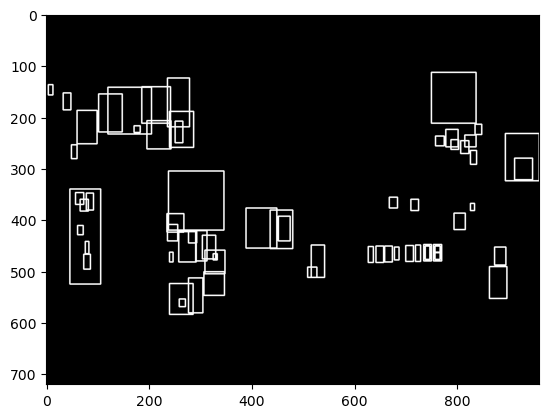

In [11]:
# 차량 이미지 Select Candidates by Char Size

MIN_AREA = 90
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

count = 0

for d in contours_dict:
    #print(d['w'], d['h'])
    area = d['w'] * d['h']
    #print(area)
    ration = d['w'] / d['h']
    #print(ration)
    
    if area > MIN_AREA and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT and MAX_RATIO > ration > MIN_RATIO:
        d['idx'] = count
        count += 1
        possible_contours.append(d)


# visualize possible contours
temp_result = np.zeros((h_, w_, c), dtype = np.uint8)

for d in possible_contours:
    x1, y1, w1, h1 = d['x'], d['y'], d['w'], d['h']
    #print(x1, y1, w1, h1)
    cv2.rectangle(temp_result, pt1 = (d['x'], d['y']), pt2 = (d['x'] + d['w'], d['y'] + d['h']), color = (255, 255, 255), thickness = 2)
    
plt.imshow(temp_result, 'gray')
plt.show()

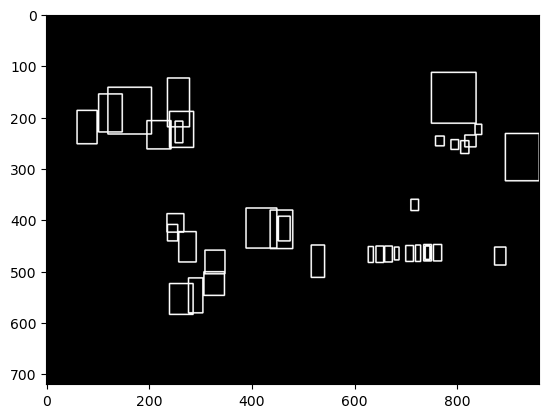

In [20]:
# 차량 이미지 Select Candidates by Arrangement of Contours 변환
# 다시 해보기..
MAX_DIAG_MULTIPLIER = 5
MAX_ANGLE_DIFF = 12.0
MAX_AREA_DIFF = 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3

def find_chars(contour_list): #문자 찾기
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contour_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue
            
            dx = abs(d1['cx']) - d2['cx']
            dy = abs(d1['cy']) - d2['cy']
            
            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d2['h'] ** 2)
            
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']
            
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLIER and angle_diff < MAX_ANGLE_DIFF \
            and area_diff < MAX_AREA_DIFF and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contour_idx.append(d2['idx'])
                
        matched_contour_idx.append(d1['idx'])
       
        if len(matched_contour_idx) < MIN_N_MATCHED:
            continue
            
        matched_result_idx.append(matched_contour_idx)
        
        unmatched_contour_idx = []
        
        for d4 in contour_list:
            if d4['idx'] not in matched_contour_idx:
                unmatched_contour_idx.append(d4['idx'])
                
        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        #recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)
            
        break
        
    return matched_result_idx

result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
    
temp_result = np.zeros((h_, w_, c), dtype = np.uint8)

for r in matched_result:
    for d in r:
        cv2.rectangle(temp_result, pt1 = (d['x'], d['y']), pt2 = (d['x'] + d['w'], d['y'] + d['h']),
                                          color = (255, 255, 255), thickness = 2)
plt.imshow(temp_result, 'gray')
plt.show()